In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_palette("colorblind")

orig_inst_set = "../DACBench/dacbench/instance_sets/sigmoid/sigmoid_2D3M_train.csv"
path = Path("../data/instance_sets/selected/generated/Sigmoid/2D3M_train")
print(path.resolve())
fnames = list(path.glob("**/*.csv"))

mapper = {
    0: "instance_id",
    1: "shift_0",
    2: "slope_0",
    3: "shift_1",
    4: "slope_1",
}

D = []
for fname in fnames:
    metadata = dict(
        benchmark_id = fname.parts[-9],
        instance_set_id = fname.parts[-8],
        selected_on = fname.parts[-7],
        selection_method = fname.parts[-6],
        feature_type = fname.parts[-5],
        source_features = fname.parts[-4],
        threshold = fname.parts[-3],
        seed = fname.parts[-2],
        selector_run = fname.parts[-1].split("_")[-1].split(".")[0],
    )
    instances = pd.read_csv(fname, header=None)

    instances = instances.rename(mapper=mapper, axis="columns")
    for k, v in metadata.items():
        instances[k] = v
    D.append(instances)
df = pd.concat(D).reset_index(drop=True)
df["origin"] = "selector"
del D

orig_df = pd.read_csv(orig_inst_set, header=None).rename(mapper=mapper, axis="columns")
orig_df["origin"] = "full"
df = pd.concat([df, orig_df]).reset_index(drop=True)
df[-10:]

/scratch/hpc-prf-intexml/cbenjamins/repos/instance-dac/data/instance_sets/selected/generated/Sigmoid/2D3M_train


,instance_id,shift_0,slope_0,shift_1,slope_1,benchmark_id,instance_set_id,selected_on,selection_method,feature_type,source_features,threshold,seed,selector_run,origin
101893,290,3.264078,3.602126,7.911622,3.412818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,full
101894,291,5.957281,1.807900,1.140898,4.773643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,full
101895,292,2.283393,2.946264,1.852606,0.942306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,full
101896,293,1.500289,5.088723,9.406939,5.020260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,full
101897,294,6.126870,5.572507,2.351425,3.258208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,full
101898,295,2.814520,6.728191,-1.796191,3.244730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,full
101899,296,3.468513,4.199032,0.535812,1.347925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,full
101900,297,2.802852,1.759005,9.604932,1.956440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,full
101901,298,12.910931,4.913243,3.168172,3.664820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,full
101902,299,4.815429,2.781618,4.439820,4.005234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,full


In [2]:
groups = ["selection_method", "feature_type", "source_features", "threshold", "seed", "selector_run"]

for gid, gdf in df.groupby(groups):   
    n_instances = len(orig_df)
    n_selected = gdf["instance_id"].nunique()
    # fig, ax = plt.subplots()
    # gdf = pd.concat([orig_df, gdf]).reset_index(drop=True)
    # ax = sns.scatterplot(data=gdf, x="shift_0", y="slope_0", hue="origin", style="origin", ax=ax)
    # ax.set_title(str(gid) + f" {n_selected/n_instances:.4f}")
    # # ax = sns.scatterplot(data=df, x="shift_1", y="slope_1", marker="o", hue="origin", ax=ax)
    # plt.show()

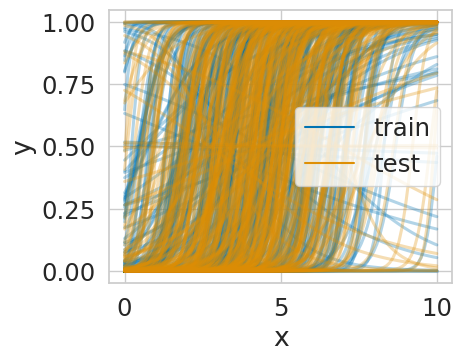

In [62]:
# Train and test instance sets
import numpy as np
import itertools

sns.set(font_scale=1.4)
sns.set_style("whitegrid")
sns.set_palette("colorblind")

def _sig(x, scaling, inflection):
    """Simple sigmoid function"""
    return 1 / (1 + np.exp(-scaling * (x - inflection)))

set_train = pd.read_csv("../DACBench/dacbench/instance_sets/sigmoid/sigmoid_2D3M_train.csv", header=None).rename(mapper=mapper, axis="columns")
set_train["origin"] = "train"
set_test = pd.read_csv("../DACBench/dacbench/instance_sets/sigmoid/sigmoid_2D3M_test.csv", header=None).rename(mapper=mapper, axis="columns")
set_test["origin"] = "test"
df = pd.concat([set_train, set_test])

# fig = plt.figure(figsize=(8,3))
# d = 2
# axes = fig.subplots(nrows=1, ncols=d)
# for i in range(d):
#     ax = axes[i]
#     ax = sns.scatterplot(data=df, x=f"shift_{i}", y=f"slope_{i}", hue="origin", ax=ax)
#     ax.legend(title=None)
#     if i == 0:
#         ax.get_legend().remove()

# fig.set_tight_layout(True)
# fig.savefig("sigmoid_train_test_space.pdf", dpi=300, bbox_inches="tight")
# plt.show()


X = np.linspace(0, 10, 100)
Y = np.concatenate(df.apply(lambda x: _sig(X, x["slope_0"], x["shift_0"]), axis="columns").to_numpy())
X_ = np.concatenate([X] * len(df))
X_.shape
origin = ["train"] * len(X) * int(0.5*len(df)) + ["test"] * len(X) * int(0.5*len(df)) 
D = pd.DataFrame({
    "x": X_,
    "y": Y,
    "origin": origin,
    "id": np.concatenate([[i] * len(X) for i in range(len(df))]),
})



sns.set(font_scale=1.6)
sns.set_style("whitegrid")
sns.set_palette("colorblind")

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
ax = sns.lineplot(data=D, x="x", y="y", hue="origin", style="id", alpha=0.3, dashes=False, ax=ax, lw=2.2)
ax.legend(title=None)
# ax.get_legend().remove()
hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l in D["origin"].unique():
        lablout.append(l)
        handout.append(h)
ax.legend(handout, lablout)
fig.set_tight_layout(True)
fig.savefig("sigmoid_train_test_instances.pdf", bbox_inches="tight", dpi=300)
plt.show()

